<a href="https://colab.research.google.com/github/yohancsx/SmartMask/blob/main/micro_ml/BLE_Sense_SVM_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!apt-get -qq install xxd
!pip install pandas numpy matplotlib
!pip install scikit-learn
!pip install micromlgen
!pip install emlearn


Selecting previously unselected package xxd.
(Reading database ... 146456 files and directories currently installed.)
Preparing to unpack .../xxd_2%3a8.0.1453-1ubuntu1.4_amd64.deb ...
Unpacking xxd (2:8.0.1453-1ubuntu1.4) ...
Setting up xxd (2:8.0.1453-1ubuntu1.4) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
  Created wheel for micromlgen: filename=micromlgen-1.1.22-cp36-none-any.whl size=29110 sha256=6c399112e163f458785495d9900c30b58c487ff82d1a7bbc8e1ff2daa8a94fc3
  Stored in directory: /root/.cache/pip/wheels/f9/16/75/c8290b649a30da3df82841b51cab894914fa7fa3085c6b4f5c
Successfully built micromlgen
  Using cached https://files.pythonhosted.org/packages/8d/43/7339dbabbc2793718d59703aace4166f53c29ee1c202f6ff5bf8a26c4d91/pybind11-2.6.2-py2.py3-none-any.whl
  Created wheel for emlearn: filename=emlearn-0.11.6-cp36-cp36m-linux_x86_64.whl size=3056572 sha256=cf90f9bcacb37a7d852406441aab9fbfec42feb8467607c8dec3dd93e1cf9cc8
  Stored in directory: /root/.cache/pip/wheels/19/02/5a/

In [3]:
#imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import emlearn

In [6]:
#load all the data into seperate dataframes

#the name for the breathing data
breathingFile = "40s_breathing.csv"

#the name for the coughing data
coughingFile = "40s_coughing.csv"

#the filename for the talking data
talkingFile = "40s_talking.csv"

#the filename for the deep breathing data
deepBreathingFile = "40s_deep_breathing.csv"

#the filename for the combined data
combinedFile = "40s_mixed.csv"

#plot some of the data on the same axes
dfTalk = (pd.read_csv("/content/" + talkingFile, index_col=False, header=None, names = ["pressure", "RMS"])).dropna(axis = 1)
dfBreathe = (pd.read_csv("/content/" + breathingFile, index_col=False, header=None, names = ["pressure", "RMS"])).dropna(axis = 1)
dfCough = (pd.read_csv("/content/" + coughingFile, index_col=False, header=None, names = ["pressure", "RMS"])).dropna(axis = 1)
dfDeepBreathe = (pd.read_csv("/content/" + deepBreathingFile, index_col=False, header=None, names = ["pressure","RMS"])).dropna(axis = 1)
dfMixed = (pd.read_csv("/content/" + talkingFile, index_col=False, header=None, names = ["pressure","RMS"])).dropna(axis = 1)

display("done loading data")

'done loading data'

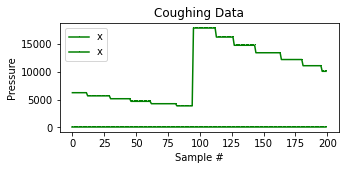

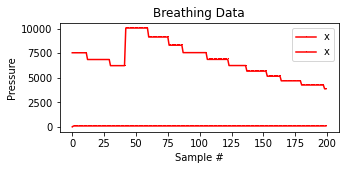

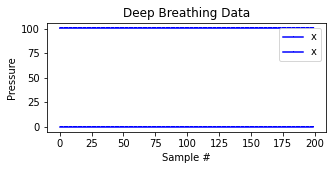

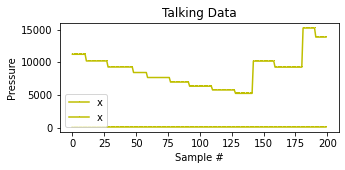

In [7]:
#plot some of the sample data
plt.rcParams["figure.figsize"] = (5,2)

#the indices
headLength = 200
index = range(0, headLength)

plt.plot(index, dfCough.head(headLength), 'g.', label='x', linestyle='solid', marker=',')
plt.title("Coughing Data")
plt.xlabel("Sample #")
plt.ylabel("Pressure")
plt.legend()
plt.show()

plt.plot(index, dfBreathe.head(headLength), 'r.', label='x', linestyle='solid', marker=',')
plt.title("Breathing Data")
plt.xlabel("Sample #")
plt.ylabel("Pressure")
plt.legend()
plt.show()

plt.plot(index, dfDeepBreathe.head(headLength), 'b.', label='x', linestyle='solid', marker=',')
plt.title("Deep Breathing Data")
plt.xlabel("Sample #")
plt.ylabel("Pressure")
plt.legend()
plt.show()

plt.plot(index, dfTalk.head(headLength), 'y.', label='x', linestyle='solid', marker=',')
plt.title("Talking Data")
plt.xlabel("Sample #")
plt.ylabel("Pressure")
plt.legend()
plt.show()



In [11]:
#prepare the datasets

#set the random seed
SEED = 2001
np.random.seed(SEED)

#the list of breathing types to classify
BREATHING_TYPES = [
    "coughing",
    "breathing",
    "talking"
]

#the classmap of breathing types (needed for exporting to arduino)
BREATHING_TYPE_MAP = {
     0:"coughing",
    1:"breathing",
    2:"talking"
}

#the list of dataframes of the breathing types
BREATHING_DATA_LIST = [dfCough,dfBreathe,dfTalk]

#the raw number of samples per period
SAMPLES_PER_PERIOD = 300

NUM_TYPES = len(BREATHING_TYPES)

#create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_TYPES = np.eye(NUM_TYPES)


#input and putput files
inputs = []
outputs = []
outputs_str = []

#set to a number far greater than the maximum number of samples (or infinity)
minsamples = np.inf

#the maximum pressure value so data is between 0 and 1
maxpressure = 3000

#the maximum RMS value
maxrms = 50000

#find the min number of samples, also the max value
for type_index in range(NUM_TYPES):
  #get the type data
  type_data = BREATHING_DATA_LIST[type_index]
  if((type_data.shape[0] - SAMPLES_PER_PERIOD/2) < minsamples):
    minsamples = type_data.shape[0] - SAMPLES_PER_PERIOD/2
  
display("minimum samples:")
display(minsamples)

'minimum samples:'

41183.0

In [6]:
#Option 1: split the dataset into overlapping portions
distance_between_samples = 20

for type_index in range(NUM_TYPES): 
  #get the type data
  type_data = BREATHING_DATA_LIST[type_index]
  #get the tensors with the samples, start by getting the first sampling period until the last
  for i in range(int(SAMPLES_PER_PERIOD/2),int(minsamples),int(distance_between_samples)):
    tensor = []
    output = ONE_HOT_ENCODED_TYPES[type_index]
    output_str = BREATHING_TYPES[type_index]
    for j in range(SAMPLES_PER_PERIOD):
      dataIndex = i + j - SAMPLES_PER_PERIOD/2
      tensor += [type_data['pressure'][dataIndex]/maxpressure,type_data['RMS'][dataIndex]/maxrms]
  
    #append the data
    inputs.append(tensor)
    outputs.append(output)
    outputs_str.append(output_str)

inputs = np.array(inputs)
outputs = np.array(outputs)
outputs_str = np.array(outputs_str)

display("input shape:")
display(inputs.shape)

display("output shape:")
display(outputs.shape)

display("output strings shape:")
display(outputs_str.shape)

'input shape:'

(196, 200)

'output shape:'

(196, 4)

'output strings shape:'

(196,)

In [12]:
#Option 2: split the dataset into non-overlapping portions
for type_index in range(NUM_TYPES):
  #get the type data
  type_data = BREATHING_DATA_LIST[type_index]

  #get the tensors with the samples, start by getting the first sampling period until the last
  for i in range(int(minsamples/SAMPLES_PER_PERIOD)):
    tensor = []
    output = ONE_HOT_ENCODED_TYPES[type_index]
    output_str = BREATHING_TYPES[type_index]
    for j in range(SAMPLES_PER_PERIOD):
      dataIndex = SAMPLES_PER_PERIOD*i + j
      tensor += [type_data['pressure'][dataIndex]/maxpressure,type_data['RMS'][dataIndex]/maxrms]
  
    #append the data
    inputs.append(tensor)
    outputs.append(output)
    outputs_str.append(output_str)

inputs = np.array(inputs)
outputs = np.array(outputs)
outputs_str = np.array(outputs_str)

display("input shape:")
display(inputs.shape)

display("output shape:")
display(outputs.shape)

display("output strings shape:")
display(outputs_str.shape)

'input shape:'

(411, 600)

'output shape:'

(411, 3)

'output strings shape:'

(411,)

In [13]:
#randomize and split inputs and outputs into training and test sets
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

#swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]
outputs_str = outputs_str[randomize]


#split the recordings (group of samples) into two sets, training and testing
TRAIN_SPLIT = int(0.7 * num_inputs)


inputs_train, inputs_test = np.split(inputs, [TRAIN_SPLIT])
outputs_train, outputs_test = np.split(outputs, [TRAIN_SPLIT])
outputs_str_train, outputs_str_test = np.split(outputs_str, [TRAIN_SPLIT])

display("input train shape:")
display(inputs_train.shape)

display("output_train shape:")
display(outputs_train.shape)

display("output_str_train shape:")
display(outputs_str_train.shape)

display("input_test shape:")
display(inputs_test.shape)

display("output_test shape:")
display(outputs_test.shape)

display("output_str_test shape:")
display(outputs_str_test.shape)

'input train shape:'

(287, 600)

'output_train shape:'

(287, 3)

'output_str_train shape:'

(287,)

'input_test shape:'

(124, 600)

'output_test shape:'

(124, 3)

'output_str_test shape:'

(124,)

In [14]:
#train SVM
lin_svm = svm.LinearSVC().fit(inputs_train, outputs_str_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [15]:
display("accuracy of SVM: ")
display(lin_svm.score(inputs_test,outputs_str_test))

'accuracy of SVM: '

0.41935483870967744

In [20]:
forest = RandomForestClassifier(n_estimators=20, max_depth=20)
forest.fit(inputs_train, outputs_str_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [21]:
display("accuracy of forest: ")
display(forest.score(inputs_test,outputs_str_test))

'accuracy of forest: '

0.9516129032258065

In [23]:
#export
cmodel = emlearn.convert(forest, method='inline')
cmodel.save(file='sonar.h')

'\n    // !!! This file is generated using emlearn !!!\n\n    #include <eml_trees.h>\n    \n\nEmlTreesNode sonar_nodes[287] = {\n  { 444, 0.0336016658693552, 1, 4 },\n  { 528, 0.03359833359718323, 2, 11 },\n  { 498, 0.03358833305537701, 3, 6 },\n  { 213, 0.31665000319480896, 4, 5 },\n  { -1, 1, -1, -1 },\n  { -1, 2, -1, -1 },\n  { 252, 0.03359833359718323, 7, 5 },\n  { 200, 0.033578332513570786, 4, 8 },\n  { 381, 0.3048899918794632, 9, 10 },\n  { -1, 0, -1, -1 },\n  { 309, 0.22288000583648682, 5, 9 },\n  { 330, 0.033586667850613594, 4, 12 },\n  { 308, 0.0336016658693552, 13, 15 },\n  { 543, 0.49970000982284546, 5, 14 },\n  { 363, 0.5289699882268906, 5, 9 },\n  { 90, 0.0336016658693552, 9, 5 },\n  { 492, 0.0336016658693552, 17, 31 },\n  { 372, 0.03359833359718323, 18, 28 },\n  { 323, 0.31780000030994415, 19, 23 },\n  { 332, 0.03358833305537701, 20, 21 },\n  { 419, 0.40625, 4, 5 },\n  { 534, 0.03359833359718323, 22, 5 },\n  { 558, 0.033586665987968445, 4, 9 },\n  { 165, 0.259250000119209